In [1]:
%matplotlib inline
import numpy as np
import pylab as P
import uvtools

In [2]:
from scipy.signal import blackmanharris

In [3]:
# Load data from Aaron's file
dat = np.load("philbull_data.npz")
d = dat['d']
w = dat['w']
times = dat['times']
fqs = dat['fqs']

In [4]:
def estimate_corrmat(d):
    """
    Estimate correlation matrix using FFT.
    """
    # Absolute value corrmat
    y = np.abs(d)
    y -= np.mean(y)
    Fy = np.fft.fft2(y)
    corr_abs = np.fft.ifft2(Fy * Fy.conj())
    
    # Phase correlation matrix
    y = np.angle(d)
    y -= np.mean(y)
    Fy = np.fft.fft2(y)
    corr_phs = np.fft.ifft2(Fy * Fy.conj())
    
    return corr_abs, corr_phs

In [5]:
def fill_linear_interp(d, w):
    """
    Fill missing data using linear interpolation along the frequency direction.
    """
    d_new = d * w
    
    # Loop over times
    for i in range(d.shape[0]):
        
        # Find continguous masked pixels
        idxs = np.where(w[i] == 0.)[0]
        start = [idxs[0],]; stop = []
        for j in range(1, len(idxs)):
            if (idxs[j] - idxs[j-1]) > 1:
                stop.append(idxs[j-1])
                start.append(idxs[j])
        if len(start) > len(stop):
            stop.append(idxs[-1])
        
        # Linear interpolation across contiguous mask
        for a, b in zip(start, stop):
            if a < 1: continue
            y1 = d_new[i,a-1]
            y2 = y1 if b >= w[i].size-1 else d_new[i,b+1]
            dx = np.arange(b - a + 1) + 1.
            grad = (y2 - y1) / (dx[-1] + 1.)
            d_new[i,a:b+1] = y1 + grad * dx
    return d_new

# Fill the mask with a simple linear interpolation

In [6]:
d_new = fill_linear_interp(d, w)

/home/phil/.local/lib/python2.7/site-packages/uvtools-0.0.0-py2.7.egg/uvtools/plot.py:13: RuntimeWarning: divide by zero encountered in log10


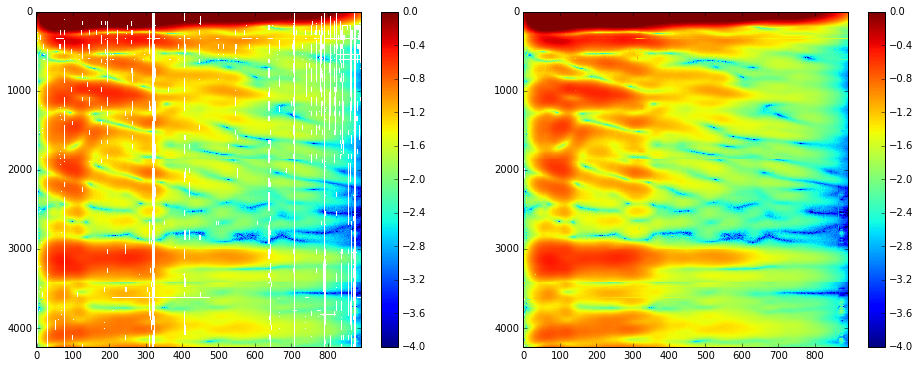

In [7]:
P.subplot(121)
uvtools.plot.waterfall(d*w, mx=0, drng=4, mode='log')
P.colorbar()

P.subplot(122)
uvtools.plot.waterfall(d_new, mx=0, drng=4, mode='log')
P.colorbar()
P.gcf().set_size_inches((16., 6.))
P.show()

# Calculate correlation functions

In [8]:
corr_abs, corr_phs = estimate_corrmat(d_new)

In [9]:
corr_abs1, corr_phs1 = estimate_corrmat(d*w)

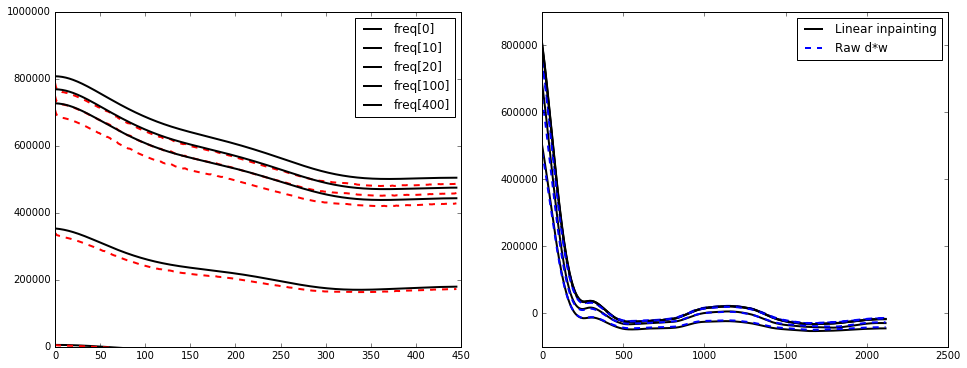

In [10]:
# Plot 1D slices through the correlation functions
ax1, ax2 = P.subplot(121), P.subplot(122)
for i in [0, 10, 20, 100, 400]:
    s1, s2 = corr_abs.shape
    ax1.plot(corr_abs.real[i,:s2/2], 'k-', lw=2., label="freq[%d]" % i)
    ax1.plot(corr_abs1.real[i,:s2/2], 'r--', lw=2.)
    
    lbl1 = "Linear inpainting" if i == 0 else None
    lbl2 = "Raw d*w" if i == 0 else None
    ax2.plot(corr_abs.real[:s1/2,i], 'k-', lw=2., label=lbl1)
    ax2.plot(corr_abs1.real[:s1/2,i], 'b--', lw=2., label=lbl2)

ax1.set_ylim((0., 1e6))
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
P.gcf().set_size_inches((16., 6.))
P.show()

In [11]:
Fcorr_abs = np.fft.fft2(corr_abs)
Fcorr_phs = np.fft.fft2(corr_phs)

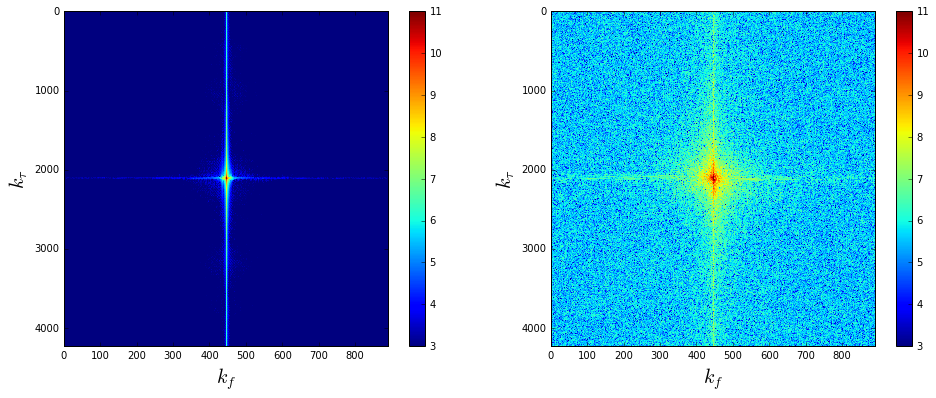

In [12]:
# Plot FFT of correlation matrix (abs value and phase)
P.subplot(121)
uvtools.plot.waterfall(np.abs( np.fft.fftshift( Fcorr_abs ) ), mx=11, drng=8, mode='log')
P.xlabel(r"$k_f$", fontsize=20)
P.ylabel(r"$k_\tau$", fontsize=20)
P.colorbar()

P.subplot(122)
uvtools.plot.waterfall(np.abs( np.fft.fftshift( Fcorr_phs ) ), mx=11, drng=8, mode='log')
P.xlabel(r"$k_f$", fontsize=20)
P.ylabel(r"$k_\tau$", fontsize=20)
P.colorbar()
P.gcf().set_size_inches((16., 6.))
P.show()

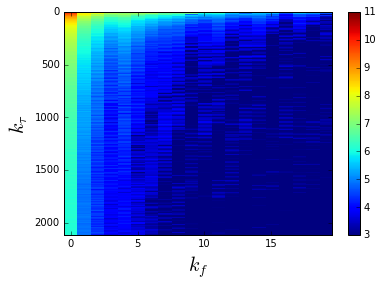

In [13]:
P.subplot(111)
uvtools.plot.waterfall(np.abs(Fcorr_abs)[:Fcorr_abs.shape[0]/2,:20], mx=11, drng=8, mode='log')
P.xlabel(r"$k_f$", fontsize=20)
P.ylabel(r"$k_\tau$", fontsize=20)
P.colorbar()
P.show()

## Apodise data before Fourier transforming
How much of the strong Fourier-space correlation in the time direction is due to non-periodicity of the window?

In [14]:
def apod_mask(shape, dx=0.1, dy=0.1, w_x=10., w_y=10.):
    """
    Build simple apodisation mask from tanh functions.
    """
    s1, s2 = shape
    x = np.ones((s1, s2))
    xx = np.linspace(-(1.+dx), 1.+dx, s1)
    yy = np.linspace(-(1.+dy), 1.+dy, s2)
    _x, _y = np.meshgrid(xx, yy)

    # Set width of tanh rolloff and build window function
    win = (1. - np.tanh(_x**w_x)) * (1. - np.tanh(_y**w_y))
    win = win.T
    return win

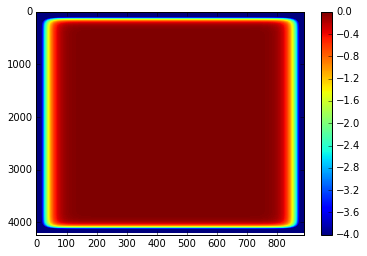

In [15]:
# Example window function
win = apod_mask(corr_abs.shape, dx=0.1, dy=0.15, w_x=40., w_y=16.)

P.subplot(111)
uvtools.plot.waterfall(win, mx=0, drng=4, mode='log')
P.colorbar()
P.show()

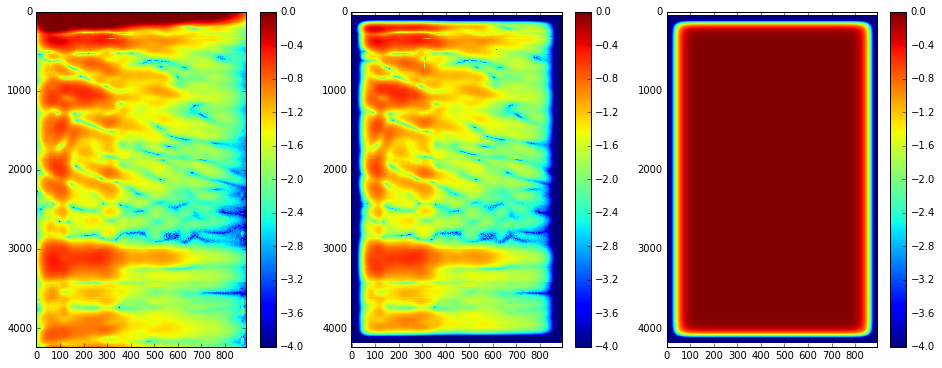

In [16]:
# Plot waterfalls of linear-inpainted and apodised data
P.subplot(131)
uvtools.plot.waterfall(d_new, mx=0, drng=4, mode='log')
P.colorbar()

P.subplot(132)
uvtools.plot.waterfall(d_new*win, mx=0, drng=4, mode='log')
P.colorbar()

P.subplot(133)
uvtools.plot.waterfall(win, mx=0, drng=4, mode='log')
P.colorbar()

P.gcf().set_size_inches((16., 6.))
P.show()

In [17]:
# Calculate correlation matrix
ap_corr_abs, ap_corr_phs = estimate_corrmat(d_new*win)

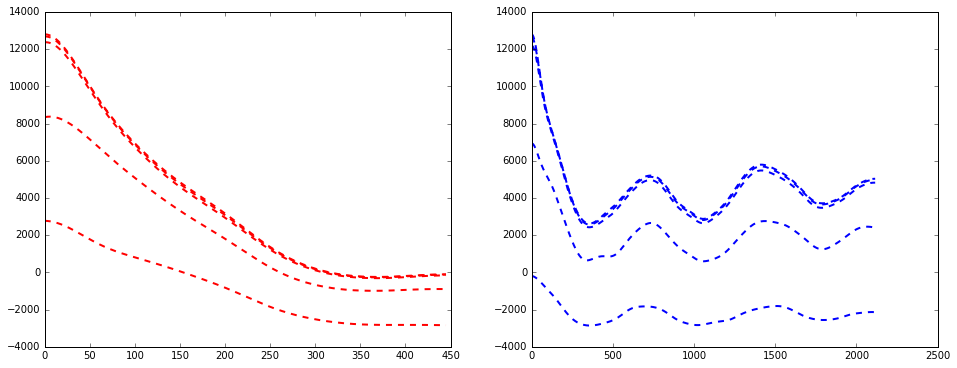

In [18]:
# Plot 1D slices through the correlation functions (with and without apodisation)
ax1, ax2 = P.subplot(121), P.subplot(122)
for i in [0, 10, 20, 100, 400]:
    s1, s2 = corr_abs.shape
    #ax1.plot(corr_abs.real[i,:s2/2], 'k-', lw=2., label="freq[%d]" % i)
    ax1.plot(ap_corr_abs.real[i,:s2/2], 'r--', lw=2.)
    
    #ax2.plot(corr_abs.real[:s1/2,i], 'k-', lw=2., label=lbl1)
    ax2.plot(ap_corr_abs.real[:s1/2,i], 'b--', lw=2.)

P.gcf().set_size_inches((16., 6.))
P.show()

In [19]:
# FFT of correlation matrix
ap_Fcorr_abs = np.fft.fft2(ap_corr_abs)

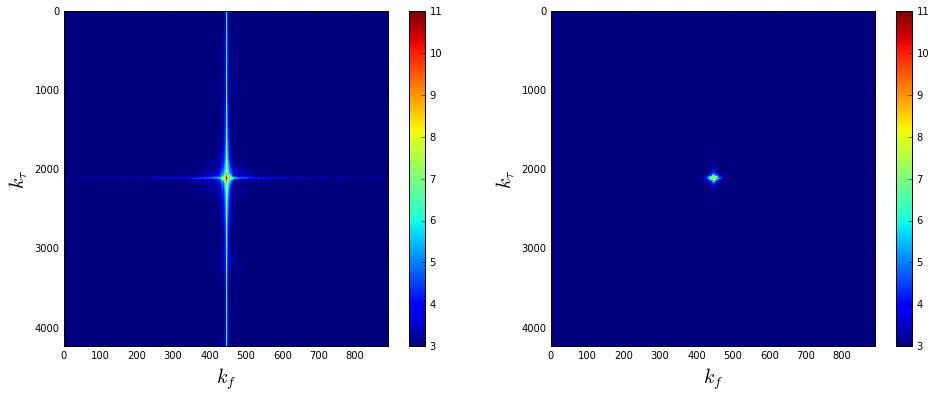

In [20]:
# Plot FFT of correlation matrix (without/with apodisation)
P.subplot(121)
uvtools.plot.waterfall(np.abs( np.fft.fftshift( Fcorr_abs ) ), mx=11, drng=8, mode='log')
P.xlabel(r"$k_f$", fontsize=20)
P.ylabel(r"$k_\tau$", fontsize=20)
P.colorbar()

P.subplot(122)
uvtools.plot.waterfall(np.abs( np.fft.fftshift( ap_Fcorr_abs ) ), mx=11, drng=8, mode='log')
P.xlabel(r"$k_f$", fontsize=20)
P.ylabel(r"$k_\tau$", fontsize=20)
P.colorbar()

P.gcf().set_size_inches((16., 6.))
P.show()

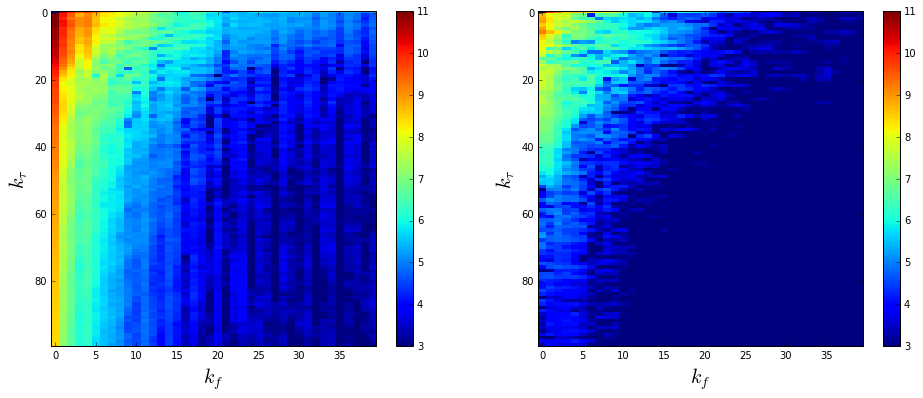

In [21]:
P.subplot(121)
uvtools.plot.waterfall(np.abs(Fcorr_abs)[:100,:40], mx=11, drng=8, mode='log')
P.xlabel(r"$k_f$", fontsize=20)
P.ylabel(r"$k_\tau$", fontsize=20)
P.colorbar()

P.subplot(122)
#uvtools.plot.waterfall(np.abs(ap_Fcorr_abs)[:ap_Fcorr_abs.shape[0]/2,:20], mx=11, drng=8, mode='log')
uvtools.plot.waterfall(np.abs(ap_Fcorr_abs)[:100,:40], mx=11, drng=8, mode='log')
P.xlabel(r"$k_f$", fontsize=20)
P.ylabel(r"$k_\tau$", fontsize=20)
P.colorbar()

P.gcf().set_size_inches((16., 6.))
P.show()

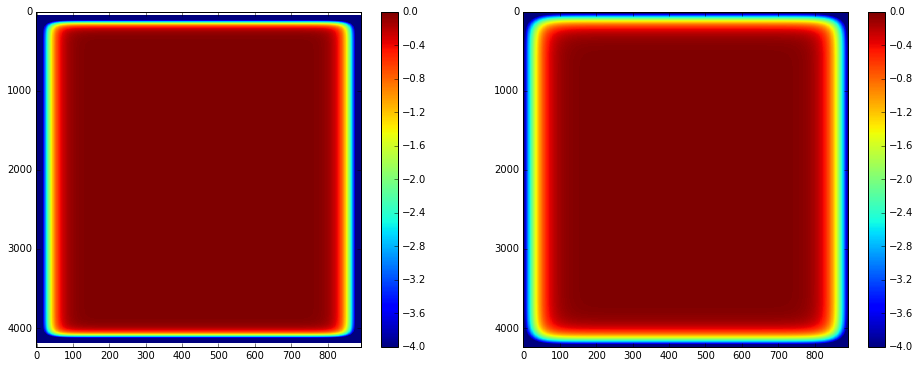

In [22]:
# Example window function
win2 = apod_mask(corr_abs.shape, dx=0.1, dy=0.15, w_x=20., w_y=12.)

P.subplot(121)
uvtools.plot.waterfall(win, mx=0, drng=4, mode='log')
P.colorbar()

P.subplot(122)
uvtools.plot.waterfall(win2, mx=0, drng=4, mode='log')
P.colorbar()

P.gcf().set_size_inches((16., 6.))
P.show()

ap_corr_abs2, ap_corr_phs2 = estimate_corrmat(d_new*win2)
ap_Fcorr_abs2 = np.fft.fft2(ap_corr_abs2)

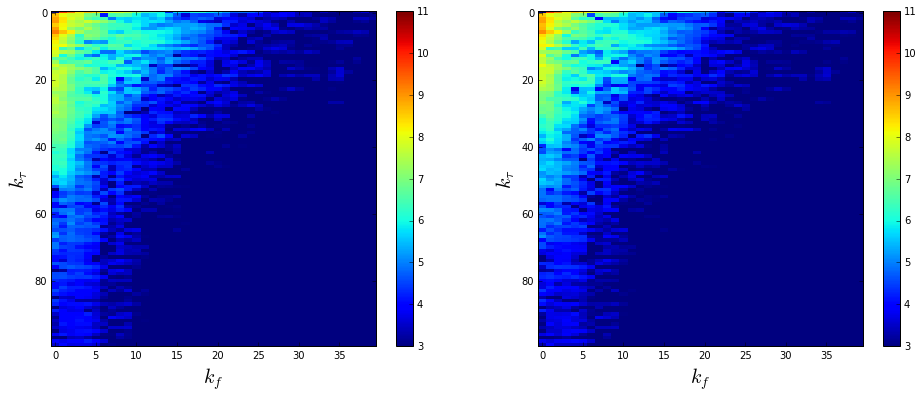

In [23]:
# Plot low-k part of correlation matrix FFT with two different apodisations
P.subplot(121)
uvtools.plot.waterfall(np.abs(ap_Fcorr_abs)[:100,:40], mx=11, drng=8, mode='log')
P.xlabel(r"$k_f$", fontsize=20)
P.ylabel(r"$k_\tau$", fontsize=20)
P.colorbar()

P.subplot(122)
uvtools.plot.waterfall(np.abs(ap_Fcorr_abs2)[:100,:40], mx=11, drng=8, mode='log')
P.xlabel(r"$k_f$", fontsize=20)
P.ylabel(r"$k_\tau$", fontsize=20)
P.colorbar()

P.gcf().set_size_inches((16., 6.))
P.show()

# 1D Wiener filter
Test method to self-consistently fill-in RFI gaps. Uses empirical covariance as the signal covariance matrix.

In [24]:
# Plot covariance matrix in the frequency direction, for linear-filled, apodised data
win1 = apod_mask(d.shape, dx=0.1, dy=0.15, w_x=20., w_y=12.)
corr1x_abs, corr1x_phs = estimate_corrmat(d_new)
corr1_abs, corr1_phs = estimate_corrmat(d_new*win1)

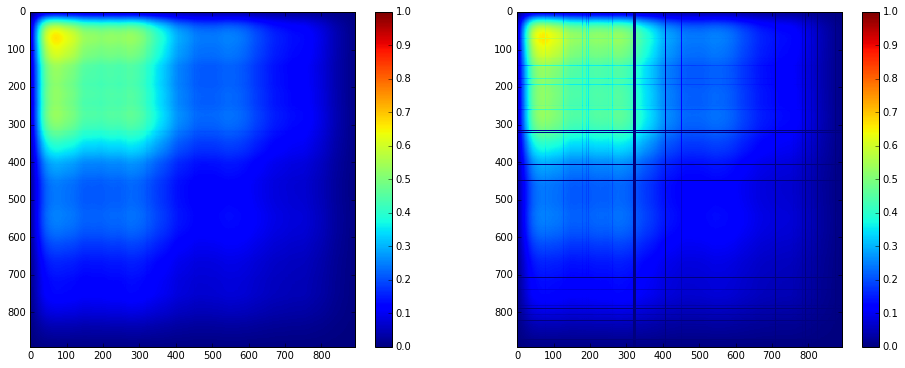

In [25]:
# Construct alternative correlation matrix model from PCA
# Average over times
cov = np.cov(d_new, rowvar=False) # Average over time samples
cov_apod = np.cov(d_new*win1, rowvar=False)
cov_raw = np.cov(d*w, rowvar=False)

P.subplot(121)
uvtools.plot.waterfall(cov, mx=1., mode='lin')
P.colorbar()

P.subplot(122)
uvtools.plot.waterfall(cov_raw, mx=1., mode='lin')
P.colorbar()

P.gcf().set_size_inches((16., 6.))
P.show()

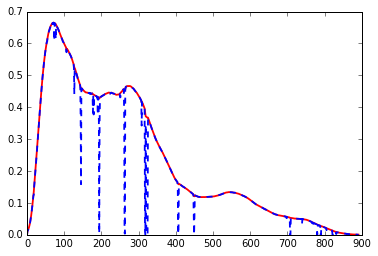

In [26]:
#P.plot(np.abs(corr1_abs[0,:])[:corr1_abs.shape[1]/2], 'k-', lw=1.8)
P.plot(np.diag(np.abs(cov)), 'r-', lw=1.8)
P.plot(np.diag(np.abs(cov_raw)), 'b--', lw=1.8)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),)
(array([0]),)
(0.0273153664355+0j)


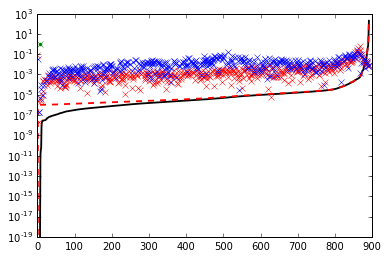

In [27]:
# Apply ridge adjustment to covariance matrix
covr = cov + 1e-6 * np.eye(cov.shape[0])

# Eigenvalue decomposition of covariance matrix
w0, v0 = np.linalg.eigh(np.abs(cov))
wr, vr = np.linalg.eigh(np.abs(covr))

print np.where(w0 < 1e-10)
print np.where(wr < 1e-10)

print np.dot(vr[0].T, np.dot(covr, vr[0]))

P.subplot(111)
#uvtools.plot.waterfall(np.linalg.inv(cov), mx=0., drng=5., mode='log')
#P.colorbar()
P.plot(w0, 'k-', lw=1.8)
P.plot(wr, 'r--', lw=1.8)
P.plot(vr[0], 'g.')
P.plot(v0[0], 'gx')
P.plot(v0[1], 'rx')
P.plot(v0[2], 'bx')
P.yscale('log')
P.show()

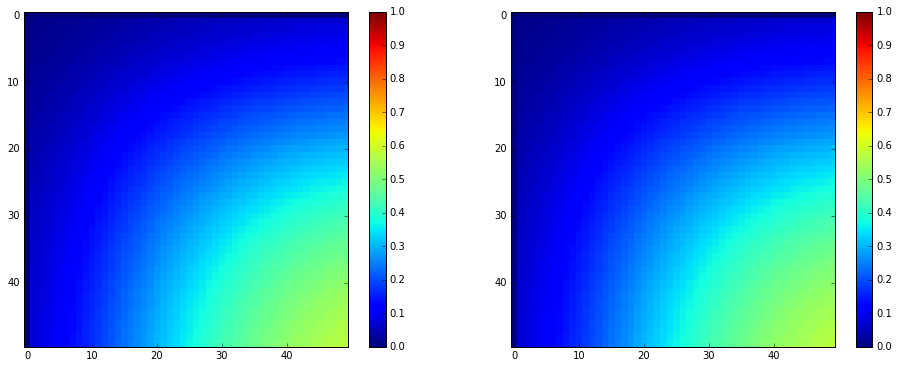

In [28]:
P.subplot(121)
uvtools.plot.waterfall(cov[:50,:50], mx=1., mode='lin')
P.colorbar()

P.subplot(122)
uvtools.plot.waterfall(covr[:50,:50], mx=1., mode='lin')
P.colorbar()

P.gcf().set_size_inches((16., 6.))
P.show()

/home/phil/.local/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


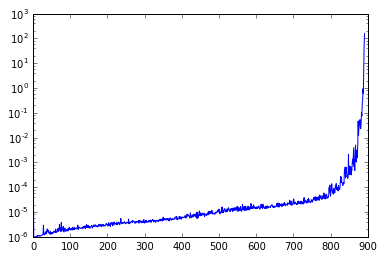

In [29]:
L = np.dot(vr.T, np.dot(covr, vr))
P.plot(np.diag(L))
P.yscale('log')

## Construct covariance with ridge adjustment
Need to make sure that there are no singularities; then invert.

In [30]:
# Apply ridge adjustment to covariance matrix
covr = cov + 7e-5 * np.eye(cov.shape[0])
wr, vr = np.linalg.eigh(np.abs(covr))
print np.where(wr < 1e-10)

(array([], dtype=int64),)


In [31]:
# Invert covariance and plot
icovr = np.linalg.inv(covr)

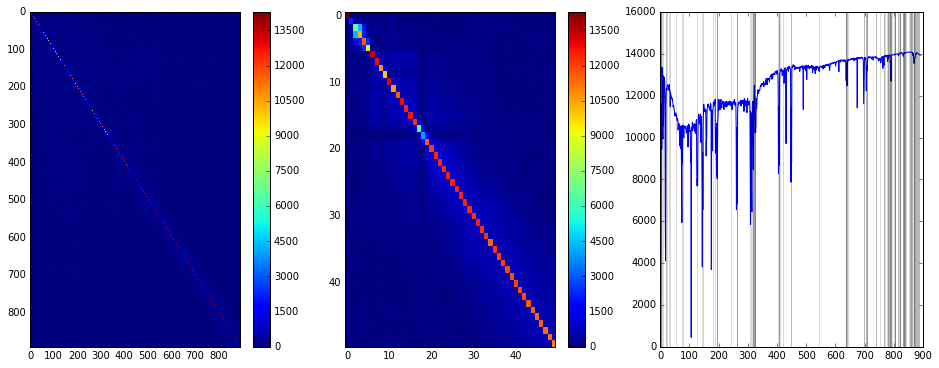

In [38]:
P.subplot(131)
uvtools.plot.waterfall(icovr, mode='lin')
P.colorbar()

P.subplot(132)
uvtools.plot.waterfall(icovr[:50,:50], mode='lin')
P.colorbar()

P.subplot(133)
P.plot(np.diag(icovr), 'b-')

w_mean = np.mean(w, axis=0)
for i in range(w_mean.size):
    if w_mean[i] < 0.9: P.axvline(i, color='k', alpha=0.15)


P.gcf().set_size_inches((16., 6.))
P.show()

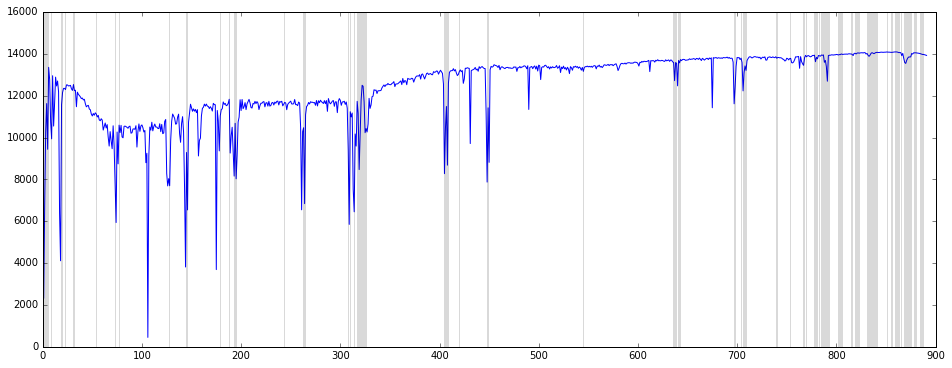

In [39]:
P.subplot(111)
P.plot(np.diag(icovr), 'b-')

w_mean = np.mean(w, axis=0)
for i in range(w_mean.size):
    if w_mean[i] < 0.9: P.axvline(i, color='k', alpha=0.15)


P.gcf().set_size_inches((16., 6.))
P.show()